In [10]:
# 1.Load and normalize the CIFAR10 training and test datasets using torchvision
# 2.Define a Convolutional Neural Network
# 3.Define a loss function
# 4.Train the network on the training data
# 5.Test the network on the test data

In [23]:
import torch
import torchvision
import torchvision.transforms as transforms

In [24]:
# Train on GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [25]:
# transform: do the preprocess(crop, resize...) at input images
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


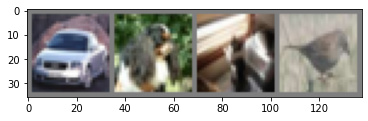

car   dog   cat   bird 


In [26]:
# show some training images
import matplotlib.pyplot as plt
import numpy as np

# function to show the image

def imshow(img):
    img = img / 2 + 0.5    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [27]:
# Define a Convolutional Neural Network
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(128, 128, 5)
        self.fc1 = nn.Linear(128 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)    # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

net.to(device)

Net(
  (conv1): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [28]:
# Define a Loss and Optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [29]:
# Traing the network
for epoch in range(2):    # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs, data is a list of [inouts, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 ==1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print("Finished Training")
    

[1,  2000] loss: 2.018
[1,  4000] loss: 1.641
[1,  6000] loss: 1.515
[1,  8000] loss: 1.376
[1, 10000] loss: 1.293
[1, 12000] loss: 1.221
[2,  2000] loss: 1.119
[2,  4000] loss: 1.089
[2,  6000] loss: 1.035
[2,  8000] loss: 1.012
[2, 10000] loss: 0.995
[2, 12000] loss: 0.967
Finished Training


In [30]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

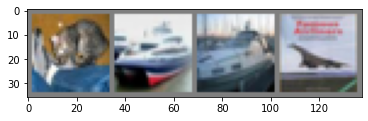

GroundTruth:  cat   ship  ship  plane


In [31]:
# Test the network on test data
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [32]:
# Load model and test
net = Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   ship  ship  ship 


In [33]:
# Network performance on whole dataset
correct = 0
total = 0
# since we're not training , we don't need to calculate the gradients for out outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 66 %


In [34]:
# Performance analysis
# prepare to count predictions dor each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 56.4 %
Accuracy for class: car   is 85.8 %
Accuracy for class: bird  is 60.3 %
Accuracy for class: cat   is 57.9 %
Accuracy for class: deer  is 44.8 %
Accuracy for class: dog   is 46.6 %
Accuracy for class: frog  is 76.2 %
Accuracy for class: horse is 73.0 %
Accuracy for class: ship  is 88.4 %
Accuracy for class: truck is 76.6 %
